### Import necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data

In [2]:
raw_data = pd.read_csv('../data/input/train.csv')
print(raw_data.shape)
raw_data.head()

(2000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
raw_data.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

### Conduct EDA

In [4]:
# Create lists for object and numerical columns
object_cols = [col for col in raw_data.columns if raw_data[col].dtype == 'object']
numerical_cols = [col for col in raw_data.columns if raw_data[col].dtype in ['int64', 'float64']]

print(f'Number of categorical variables: {len(object_cols)}')
print(f'Number of numerical variables: {len(numerical_cols)}')

Number of categorical variables: 0
Number of numerical variables: 21


In [5]:
# Plot missing values for each variable

def plot_missing_vals(data):
    na_dict = {}

    # Get a count of missing values for each variable
    for var in data.columns:
        total_na = data[var].isnull().sum()
        percent_na = (total_na/len(data))*100
        na_dict[var] = percent_na
        
    cols = list(na_dict.keys())
    percent_na = list(na_dict.values())

    fig, ax = plt.subplots(1,1, figsize = (15,6))
    ax.bar(cols, percent_na, color = 'maroon', width=0.4)
    ax.set_title("Percentage of missing values in each variable")
    ax.set_xlabel("Variables")
    ax.set_ylabel("Percentage(%)")
    ax.set_ylim(0,100)
    ax.set_xticklabels(cols, rotation=90)

    return fig,ax

/Users/hassansaad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 1080x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Percentage of missing values in each variable'}, xlabel='Variables', ylabel='Percentage(%)'>)

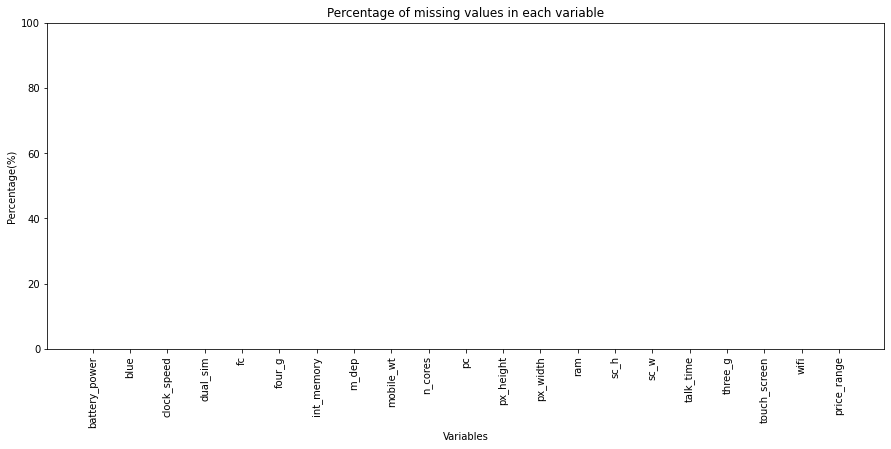

In [6]:
plot_missing_vals(raw_data)

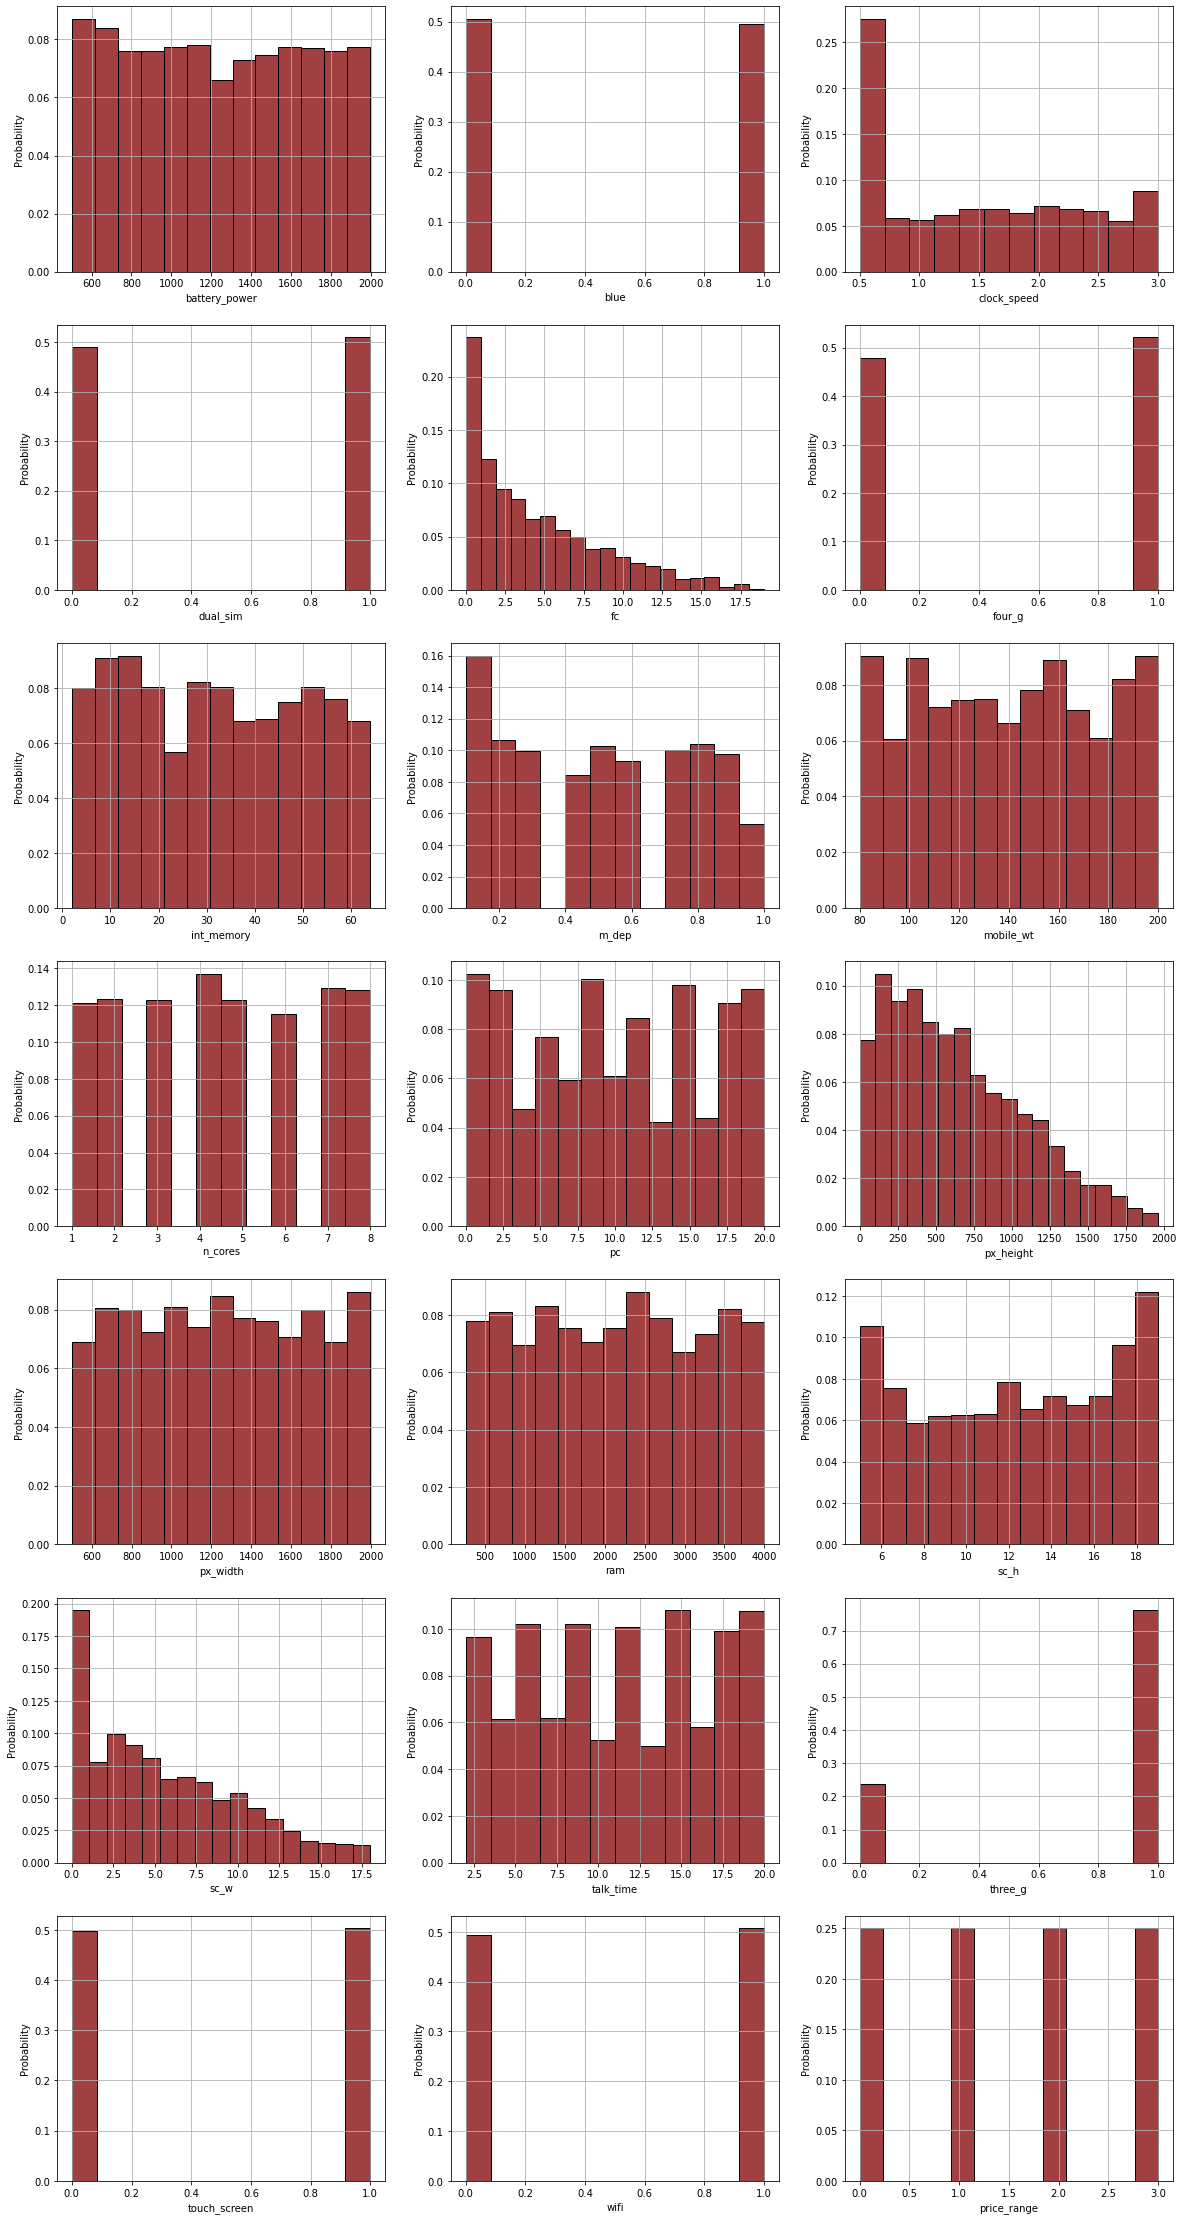

In [7]:
# Create histograms for the distribution of all numerical variables
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20,40))

for axis,col in zip(axes.flatten(), numerical_cols):
    sns.histplot(data=raw_data, x=col, stat='probability', color='maroon', ax=axis)
    axis.grid(True)

# sc_w, clock_speed, fc may need to be power transformed before fitting classification model. 

In [8]:
raw_data.price_range.value_counts(normalize=True)

1    0.25
2    0.25
3    0.25
0    0.25
Name: price_range, dtype: float64

<AxesSubplot:>

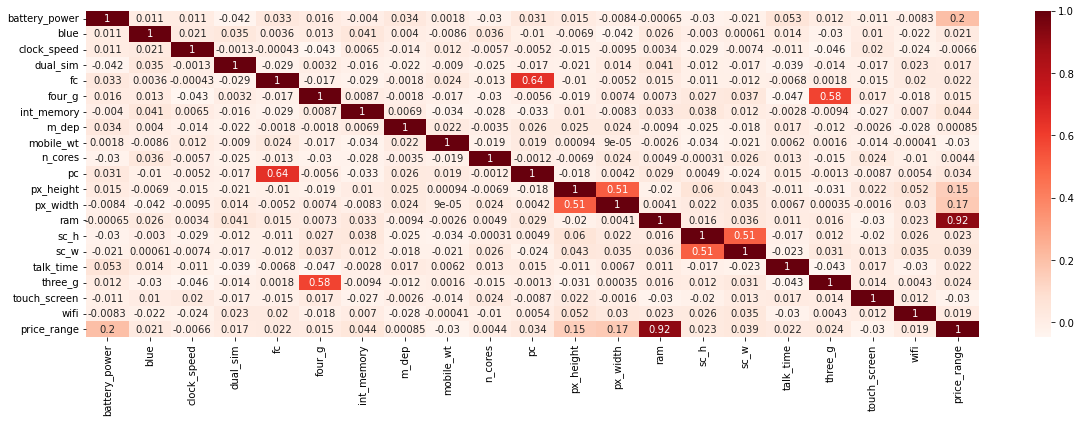

In [9]:
# Check correlation map
fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.heatmap(raw_data[numerical_cols].corr(), annot=True, cmap='Reds')

### Model Fitting

In [10]:
from sklearn.model_selection import train_test_split

X = raw_data.drop('price_range',axis=1)
y = raw_data['price_range']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= 0.2, random_state=1, stratify=y) 

In [11]:
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Create lists for object and numerical columns
object_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
log_cols = ['sc_w','clock_speed','fc']

pw = PowerTransformer()
X_train[log_cols] = pw.fit_transform(X_train[log_cols])
X_test[log_cols] = pw.transform(X_test[log_cols])

sc = StandardScaler()
X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.transform(X_test[numerical_cols])


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

model_pipeline=[]
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(LogisticRegression(solver='saga',random_state=42,multi_class='multinomial'))
model_pipeline.append(SVC(random_state=45))
model_pipeline.append(DecisionTreeClassifier(random_state=42))
model_pipeline.append(RandomForestClassifier(random_state=42))
model_pipeline.append(XGBClassifier(random_state = 42))
model_pipeline.append(lgb.LGBMClassifier(random_state = 42))

In [13]:
model_list=['KNN', 'Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGB', 'Light GBM']
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

acc=[]
f1=[]
precision=[]
recall=[]

for classifier in model_pipeline:
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    acc.append(round(accuracy_score(Y_test, Y_pred),2))
    f1.append(f1_score(Y_test, Y_pred, average = "weighted"))
    precision.append(precision_score(Y_test, Y_pred, average = "weighted"))
    recall.append(recall_score(Y_test, Y_pred, average = "weighted"))


/Users/hassansaad/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
result=pd.DataFrame({'Model': model_list, 'Accuracy': acc, 'F1 Score': f1, 'Precision': precision, 'Recall': recall})
result

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.51,0.514373,0.530185,0.5100
1,Logistic Regression,0.97,0.969712,0.971062,0.9700
2,SVM,0.86,0.865181,0.865422,0.8650
3,Decision Tree,0.83,0.829268,0.830737,0.8300
4,Random Forest,0.88,0.884306,0.884451,0.8850
5,XGB,0.91,0.906954,0.907368,0.9075
6,Light GBM,0.90,0.894779,0.895665,0.8950


In [17]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

### Hyperparameter Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(max_iter = 1000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,Y_train)

print("Best Parameters",logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)

/Users/hassansaad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hassansaad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hassansaad/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/hassansaad/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

Best Parameters {'C': 1000.0, 'penalty': 'l2'}
Accuracy : 0.9662499999999999


### Create pipeline

In [21]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer

# Create objects for categorical features and numerical features
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
log_cols = ['sc_w','clock_speed','fc']

# Make pipeline for numerical variable transformations
log_pipe = make_pipeline(PowerTransformer())
standard_pipe = make_pipeline(StandardScaler())

# Make full processor
full = ColumnTransformer(
    transformers=[
        ("log", log_pipe, log_cols),
        ("standardize", standard_pipe, numerical_cols),
    ]
)

# Final pipeline
final_pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        ("fit", LogisticRegression(penalty = 'l2', C = 1000.0, max_iter=1000)),
    ]
)

final_pipeline.fit(X,y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['sc_w', 'clock_speed',
                                                   'fc']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_power', 'blue',
                                                   'clock_speed', 'dual_sim',
                                                   'fc', 'four_g', 'int_memory',
                                                   'm_dep', 'mobile_wt',
                                                   'n_co